In [1]:
import tensorflow.keras.backend as K
import itertools
import matplotlib
import scipy
import sklearn
from matplotlib import pyplot as plt
from datetime import datetime
from functools import partial
import pickle

import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from transformers import TFAutoModel, AutoTokenizer

from sklearn.preprocessing import StandardScaler

# import cudf
# import cuml
# import cupy
# from cuml.feature_extraction.text import TfidfVectorizer
# from cuml.neighbors import NearestNeighbors

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device: ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    DEVICE = "TPU"
except:
    DEVICE = 'notTPU'
    strategy = tf.distribute.get_strategy()
print(DEVICE)

AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 200
BATCH_SIZE = 32*strategy.num_replicas_in_sync
MODEL = '../input/tfroberta-base-indonesian/roberta-base-indonesian-522M'

CLASSES = 11014

Device:  grpc://10.0.0.2:8470
TPU


In [3]:
train = pd.read_parquet(f"../input/shopee-text-cleaner-roberta-base-id-all/train.parquet", engine='pyarrow')

x_train = train[['input_ids', 'att_mask', 'title_vec']].values
y_train = train['label_group'].values

inp1 = [x.tolist() for x in x_train[:,0]]
inp2 = [x.tolist() for x in x_train[:,1]]
inp3 = [x.tolist() for x in x_train[:,2]]

In [4]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(((inp1, inp2, inp3, y_train), y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

del inp1, inp2, inp3

In [5]:
from tensorflow.keras.models import Model, Sequential
import keras.backend as K
from keras.optimizers import SGD
from tensorflow.keras.layers import (
    Input, 
    Flatten, 
    Dense, 
    Dropout, 
    AveragePooling2D, 
    GlobalAveragePooling2D, 
    SpatialDropout2D, 
    BatchNormalization, 
    Activation, 
    Concatenate,
    Embedding,
    GlobalAveragePooling1D,
    Lambda
)

In [6]:
def plt_lr(epoch_count):
    if epoch_count > 50:
        epoch_count = 50
    
    rng = [i for i in range(epoch_count)]

    plt.figure()
    y = [lrfn(x) for x in rng]
    plt.title(f'Learning rate schedule: {y[0]} to {y[epoch_count-1]}')
    plt.plot(rng, y)

def plt_acc(h):
    plt.figure()
    plt.plot(h.history["sparse_categorical_accuracy"])
    if 'val_sparse_categorical_accuracy' in h.history:
        plt.plot(h.history["val_sparse_categorical_accuracy"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.xlabel("epoch")
    plt.title("Sparse Categorical Accuracy")
    plt.show()
    
def plt_f1_score(h):
    plt.figure()
    plt.plot(h.history["f1_score"])
    if 'f1_score' in h.history:
        plt.plot(h.history["f1_score"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.xlabel("epoch")
    plt.title("F1 Score")
    plt.show()

def plt_loss(h):
    plt.figure()
    plt.plot(h.history["loss"])
    if 'val_loss' in h.history:
        plt.plot(h.history["val_loss"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.legend(["training","validation"])
    plt.xlabel("epoch")
    plt.title("Loss")
    plt.show()

class EpochCallback(tf.keras.callbacks.Callback):  
    def on_epoch_begin(self, epoch, logs=None):
        global current_epoch
        global chance

        current_epoch = epoch       
        if current_epoch < 2:
            chance = 0
        elif current_epoch < 9:
            chance = current_epoch - 1 # possible chance between 1 to 7
        else:
            chance = 8
        print(f'Epoch #{current_epoch}')
        print(datetime.now())

es_val_f1 = tf.keras.callbacks.EarlyStopping(
    monitor='f1_score', min_delta=0.001, patience=5, verbose=1, mode='max',
    baseline=None, restore_best_weights=True
)

es_val_f1_stage2 = tf.keras.callbacks.EarlyStopping(
    monitor='f1_score', min_delta=0.001, patience=15, verbose=1, mode='max',
    baseline=None, restore_best_weights=True
)

cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'backup_weights.h5',
    save_weights_only=True,
    monitor='f1_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

# cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     "backup.h5",
#     monitor="f1_score", verbose=1, mode='max', save_best_only=True)
cb_checkpoint._supports_tf_logs = False

epoch_cb = EpochCallback()

In [7]:
# swish activation
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

get_custom_objects().update({'swish': Activation(swish)})


In [8]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Reshape, multiply
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional, Conv1D, GlobalMaxPooling1D, Conv2D
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, Xception
# from transformers import TFXLNetModel, XLNetTokenizer
## for bert language model
import transformers

In [9]:
class ArcMarginProduct(keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False, 
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [10]:
def get_bert_model(mname = MODEL):
    
    idx = layers.Input((105), dtype="int32", name="input_idx")
    masks = layers.Input((105), dtype="int32", name="input_masks")
    
    nlp = TFAutoModel.from_pretrained(mname)
    bert_out= nlp([idx, masks])[0]
    
    ## fine-tuning
    x = layers.GlobalAveragePooling1D()(bert_out)
    x = layers.Dense(750, activation="swish", name='text-embed')(x)
    
    model_title = Sequential([
        Input(shape=(100,), name='title-input'),
        Embedding(25000, 150, input_length=100, name='title-embed'),
        Dropout(0.2),
        Conv1D(300, 3, padding='valid', activation='relu', strides=1),
        GlobalMaxPool1D(),
        Dense(720, name='title-dense1'), #650 -> 0.81
        Activation('swish', name='title-act1'),
        Dropout(0.2),
        
        Dense(650, name='title-dense2'),
        BatchNormalization(name='title-bn2'),
        Activation('swish', name='title-act2'),
    ], name='title-vec')
    
    margin = ArcMarginProduct(
        n_classes = CLASSES, 
        s = 30, 
        m = 0.7, 
        name='head/arc_margin', 
        dtype='float32'
    )
    
    concatenate = Concatenate(name='concatenate')([x, model_title.output])
    label = Input(shape=(), name='arc-input')
    arc_face = margin([concatenate, label])
    output = Dense(CLASSES, activation='softmax', name='output')(arc_face)
    
    model = Model(inputs=[idx, masks, model_title.input, label], outputs=[output])
    
    return model

# model = get_bert_model()
# model.summary()

In [11]:
def get_lr_callback():
    lr_start   = 0.000001
    lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

In [12]:
tf.tpu.experimental.initialize_tpu_system(tpu)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/tfroberta-base-indonesian/roberta-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title-input (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
title-embed (Embedding)         (None, 100, 150)     3750000     title-input[0][0]                
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 100, 150)     0           title-embed[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 98, 300)      135300      dropout_37[0][0]                 
______________________________________________________________________________________________

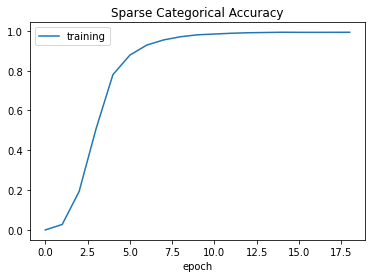

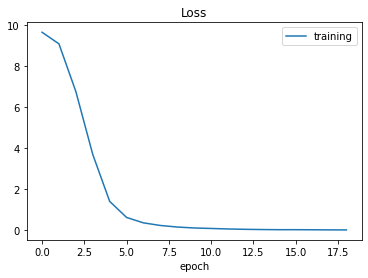

In [13]:
# fold 0: 24
# fold 1: 10
# fold 2: 9
# fold 3: 17
# avg: (24+10+9+17)/4 = 15
# total epoch: 15 + 15*25/100 = 18.75 = 19

with strategy.scope():
    model = get_bert_model()
    model.compile(
        optimizer = tfa.optimizers.LAMB(1e-5),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['sparse_categorical_accuracy']
    )
model.summary()
    
model.fit(
    train_dataset, 
    steps_per_epoch=len(x_train)//BATCH_SIZE,
    epochs = 19,
    callbacks=[get_lr_callback()], verbose=1
)

h = model.history
plt_acc(h)
plt_loss(h)

model.save_weights('model_weights.h5')